In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from cmocean import cm
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(14*2)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.1.83:57516' processes=21 threads=21, memory=359.94 GB>

__________

__________

# Combine Eta and V together, and then store

In [5]:
time_length = 24
dij=4
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

In [10]:
# 3.5 mins for 2 months (1440)
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'/Tau_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:       

        # read rechunked data
        #grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
        ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'}).isel(time=slice(0, time_length), face = face, i=slice(0,None,dij), j=slice(0,None,dij))
        ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'}).isel(time=slice(0, time_length), face = face, i=slice(0,None,dij), j=slice(0,None,dij))
        #ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr').isel(time=slice(0,None,24))

        # data merge
        E = xr.merge([ds_TAUX,ds_TAUY])
        # store
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)

        E = E.chunk({'time':1, 'i': 1080, 'j':1080})
        #print(E)
        %time E.to_zarr(Efile, mode='w')
        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

face
niter
CPU times: user 264 ms, sys: 20 ms, total: 284 ms
Wall time: 950 ms
--- face 0 done
face
niter
CPU times: user 248 ms, sys: 44 ms, total: 292 ms
Wall time: 942 ms
--- face 1 done
face
niter
CPU times: user 248 ms, sys: 20 ms, total: 268 ms
Wall time: 816 ms
--- face 2 done
face
niter
CPU times: user 224 ms, sys: 20 ms, total: 244 ms
Wall time: 573 ms
--- face 3 done
face
niter
CPU times: user 256 ms, sys: 20 ms, total: 276 ms
Wall time: 756 ms
--- face 4 done
face
niter
CPU times: user 228 ms, sys: 20 ms, total: 248 ms
Wall time: 685 ms
--- face 5 done
face
niter
CPU times: user 252 ms, sys: 16 ms, total: 268 ms
Wall time: 705 ms
--- face 6 done
face
niter
CPU times: user 248 ms, sys: 24 ms, total: 272 ms
Wall time: 723 ms
--- face 7 done
face
niter
CPU times: user 244 ms, sys: 24 ms, total: 268 ms
Wall time: 735 ms
--- face 8 done
face
niter
CPU times: user 240 ms, sys: 12 ms, total: 252 ms
Wall time: 630 ms
--- face 9 done
face
niter
CPU times: user 224 ms, sys: 32 ms, tot

In [12]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(store_dir_zarr+'Tau_f%02d.zarr'%(face)) for face in face_all] 
ds = xr.concat(D, dim='face')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080, time: 24)
Coordinates:
    niter    (time) int64 256896 257040 257184 257328 ... 259920 260064 260208
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-24T07:00:00
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    oceTAUX  (face, time, j, i) float32 dask.array<chunksize=(1, 1, 1080, 1080), meta=np.ndarray>
    oceTAUY  (face, time, j, i) float32 dask.array<chunksize=(1, 1, 1080, 1080), meta=np.ndarray>

 data size: 2.9 GB


In [14]:
grid = xr.open_zarr(out_dir_zarr+'grid.zarr').isel(i=slice(0,None,dij), j=slice(0,None,dij))
grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, i_g: 4320, j: 1080, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    Zl       (k_l) float32 

In [15]:
ds = ds.assign_coords(XC=grid.XC) 
ds['u_rotate'] = ds.oceTAUX*ds.CS - ds.oceTAUY*ds.SN
ds['v_rotate'] = ds.oceTAUX*ds.SN + ds.oceTAUY*ds.CS
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080, time: 24)
Coordinates:
    niter    (time) int64 256896 257040 257184 257328 ... 259920 260064 260208
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-24T07:00:00
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variab

In [16]:
font_size = 20

def plot_pretty_2(v1, v2, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                  offline=False, figsize=(20,12), cmmap='thermal', ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        cmap = getattr(cm, cmmap)
        
        # 1
        ax = fig.add_subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v1.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[0], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[0],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)


        # 2
        ax = fig.add_subplot(212, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v2.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=-2, vmax=2,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[1], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[1],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)        


        #if title is not None:
        #    ax.set_title(title, size=font_size)
        #if label is not None:
        #    cb.set_label(label=label, size=font_size)     #
            
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

In [17]:
vmin, vmax = -.4, .4
lds = ds

def genfig(ds, i, overwrite=True):
    
    # !! passing the variable does not work
    u = ds.u_rotate
    v = ds.v_rotate
    
    
    figname = '/home1/datahome/xyu/equinox_working/Figures/Tau_t%05d' %(i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        
    
        title = ['', '']
        label = ['u (m/s)', '$v$ (m/s)']
        
        plot_pretty_2(u, v,  vmin=vmin, vmax=vmax, cmmap='balance', title=title, label=label, savefig=figname, figsize=(20,12), ignore_face=[6])

        m = 1.
        #m = float(eta.mean().values)
    else:
        m = -1.
    return m

#I = range(len(ds['time']))
I = range(20)
print(I)
values = [delayed(genfig)(lds.isel(time=i), i) for i in I]

range(0, 20)


Process all times

In [18]:
futures = client.compute(values)
%time results = client.gather(futures)

AttributeError: 'Dataset' object has no attribute 'u_rotate'

In [7]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'TAUX_ELD_rotation_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUX_ELD_rotation = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'TAUY_ELD_rotation_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUY_ELD_rotation = xr.concat(D, dim='face')

In [8]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
ice

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    AREA     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [10]:
ds = xr.merge([ds_TAUX_ELD_rotation,ds_TAUY_ELD_rotation])
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080, time: 100)
Coordinates:
    niter      (time) int64 256896 257040 257184 257328 ... 270864 271008 271152
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * time       (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    rA         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarr

In [42]:
time_length = 100

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,11,23,8)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(time_length))
#ds = ds.assign_coords(time=time_day) 

In [ ]:
plt.rc('font', size=20) 


In [32]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 20})

In [43]:
font_size = 20

def plot_pretty_2(v1, v2, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                  offline=False, figsize=(20,12), cmmap='thermal', ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        cmap = getattr(cm, cmmap)
        
        # 1
        ax = fig.add_subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v1.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[0], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[0],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)


        # 2
        ax = fig.add_subplot(212, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v2.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[1], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[1],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)        


        #if title is not None:
        #    ax.set_title(title, size=font_size)
        #if label is not None:
        #    cb.set_label(label=label, size=font_size)     #
            
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [44]:
vmin, vmax = -4e-5, 4e-5
lds = ds

def genfig(ds, i, overwrite=True):
    
    # !! passing the variable does not work
    u = ds.oceTAUX_H
    v = ds.oceTAUY_H
    mtime = time_day[i]
    
    figname = '/home1/datahome/xyu/equinox_working/Figures/Tau_H_t%05d' %(i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        
    
        title = ['%s'%mtime, '']
        label = [r'$\tau_x/H\rho \: (m\, s^{-2})$', r'$\tau_y/H\rho \: (m\, s^{-2})$']
        
        plot_pretty_2(u, v,  vmin=vmin, vmax=vmax, cmmap='balance', title=title, label=label, savefig=figname, figsize=(20,12), ignore_face=[6])

        m = 1.
        #m = float(eta.mean().values)
    else:
        m = -1.
    return m

#I = range(len(ds['time']))
I = range(100)
print(I)
values = [delayed(genfig)(lds.isel(time=i), i) for i in I]

range(0, 100)


Process all times

In [45]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 29.1 s, sys: 1.59 s, total: 30.7 s
Wall time: 3min


# publish-able plots

In [6]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'

ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr')

# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'})
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'})
#ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr').isel(time=slice(0,None,24))

# data merge
ds = xr.merge([ds_TAUX,ds_TAUY,grid])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8585)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-15
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG 

In [9]:
oceTAUX =  ds_TAUX.oceTAUX.sel(time='2011-11-24T08:00:00')*grid.CS - ds_TAUY.oceTAUY.sel(time='2011-11-24T08:00:00')*grid.SN
oceTAUY =  ds_TAUX.oceTAUX.sel(time='2011-11-24T08:00:00')*grid.SN + ds_TAUY.oceTAUY.sel(time='2011-11-24T08:00:00')*grid.CS

In [10]:
oceTAUX_sub = oceTAUX.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
oceTAUY_sub = oceTAUY.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))

In [7]:
font_size = 20

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.23, 0.025, 0.54])
        cb = plt.colorbar(im, cax=cax)
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-75., 75.)
        ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        ax.set_ylabel('Latitude',fontsize=font_size)
        ax.set_xlabel('Longitude',fontsize=font_size)
        #ax.set_xlabel('',fontsize=font_size)
        #ax.set_ylabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=20)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

In [10]:
a = ds.oceTAUX.sel(time='2011-11-24T08:00:00').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
a

<xarray.DataArray 'oceTAUX' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float32, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    niter    int64 dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 2011-11-24T08:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chun

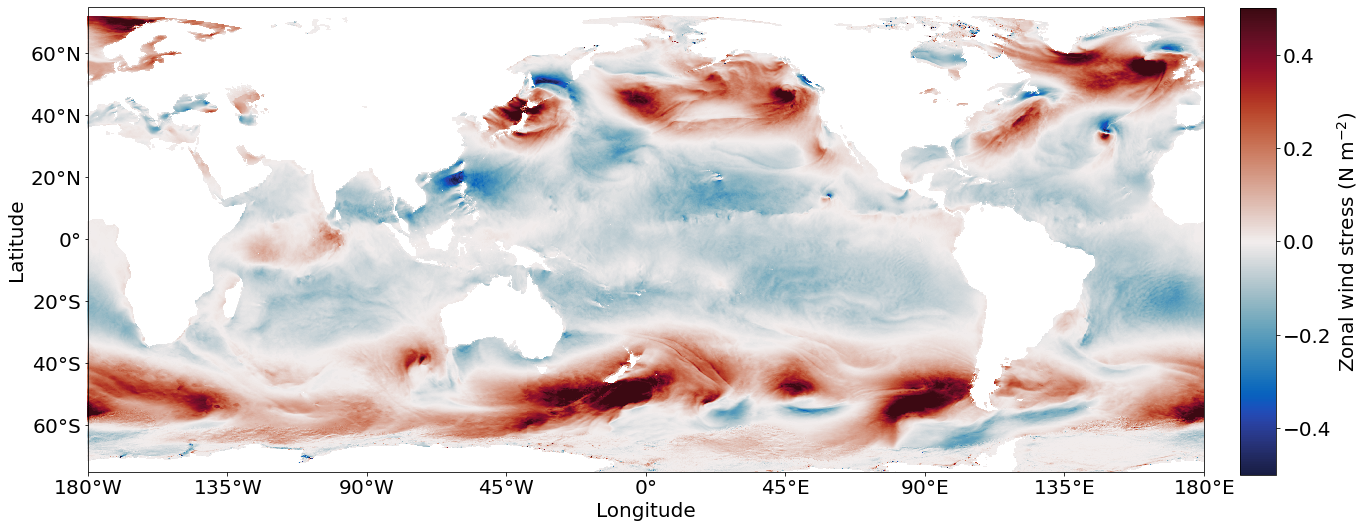

In [9]:
plot_pretty(oceTAUX.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)), label='Zonal wind stress (N m$^{-2}$)', vmin=-0.5, vmax=0.5, cmmap='balance', ignore_face=[6])

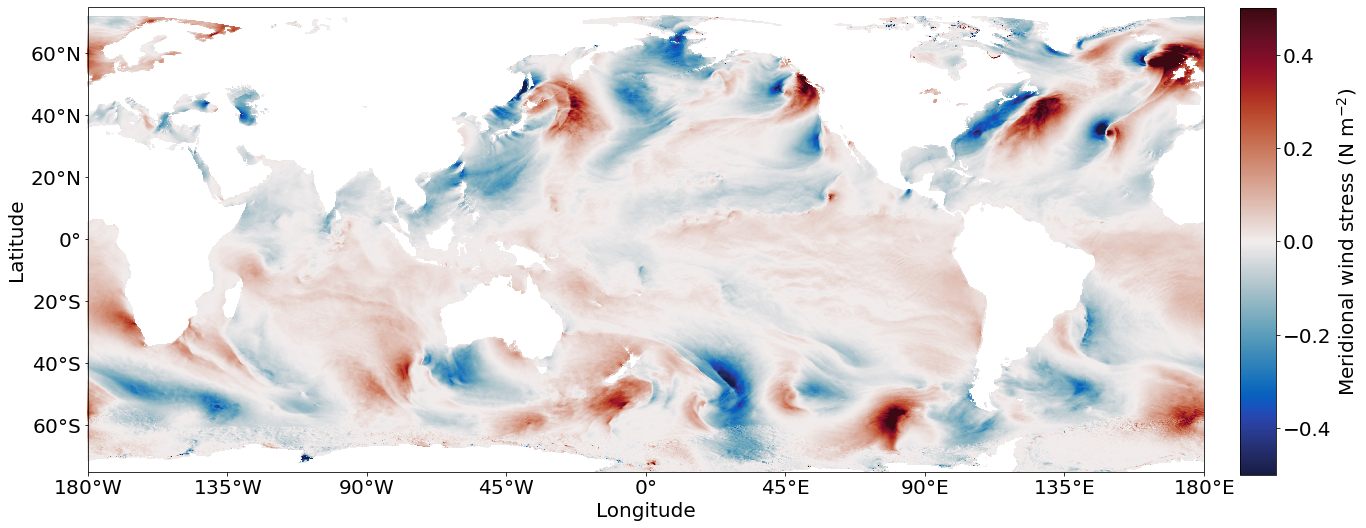

In [10]:
plot_pretty(oceTAUY.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)), label='Meridional wind stress (N m$^{-2}$)', vmin=-0.5, vmax=0.5, cmmap='balance', ignore_face=[6])

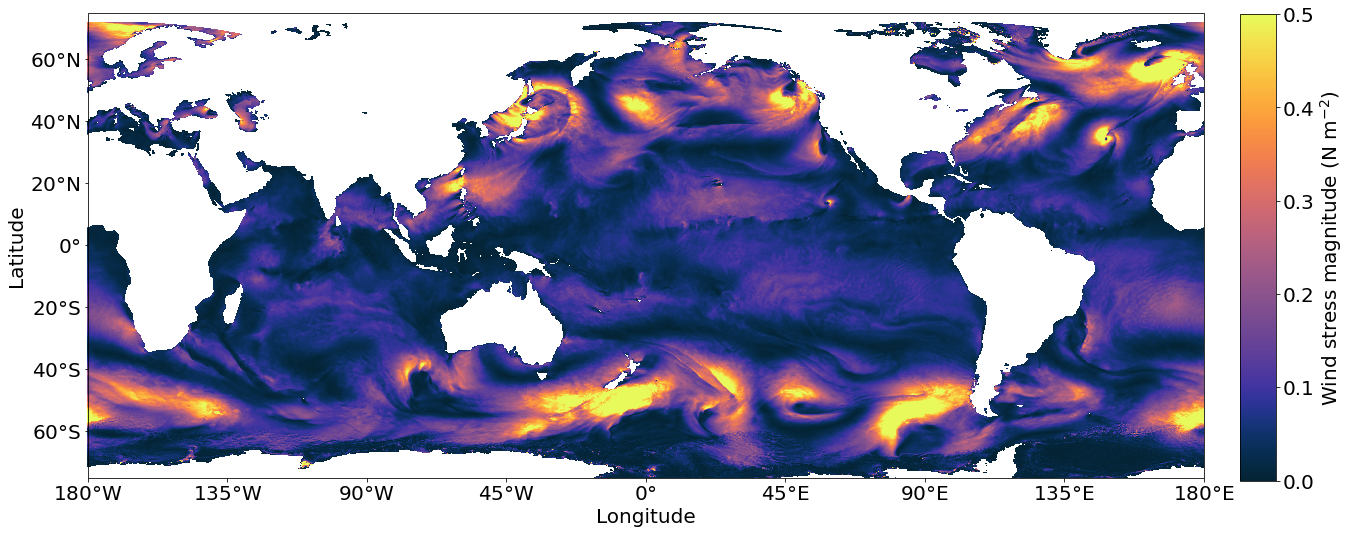

In [12]:
plot_pretty( np.sqrt(oceTAUX_sub**2 + oceTAUY_sub**2) , label='Wind stress magnitude (N m$^{-2}$)', vmin=0, vmax=0.5, cmmap='thermal', ignore_face=[6])

## A try on gradients

In [13]:
oceTAUY = np.real(oceTAUY).rename('oceTAUY')     
ds_tau = xr.merge([oceTAUY,grid])

# create the grid object
gridx = xgcm.Grid(ds_tau, coords={'X':{'center':'i', 'left':'i_g'},'Y':{'center':'j', 'left':'j_g'}}, periodic=True)

zeta = gridx.interp(gridx.diff(ds_tau.oceTAUY,'Y', boundary=None),'Y', boundary=None)
zeta = np.real(zeta).rename('zeta')     
ds_z = xr.merge([zeta,grid])
ds_z

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 432

In [ ]:
plot_pretty(ds_z.zeta, label='', vmin=-0.005, vmax=0.005, cmmap='balance', ignore_face=[6])

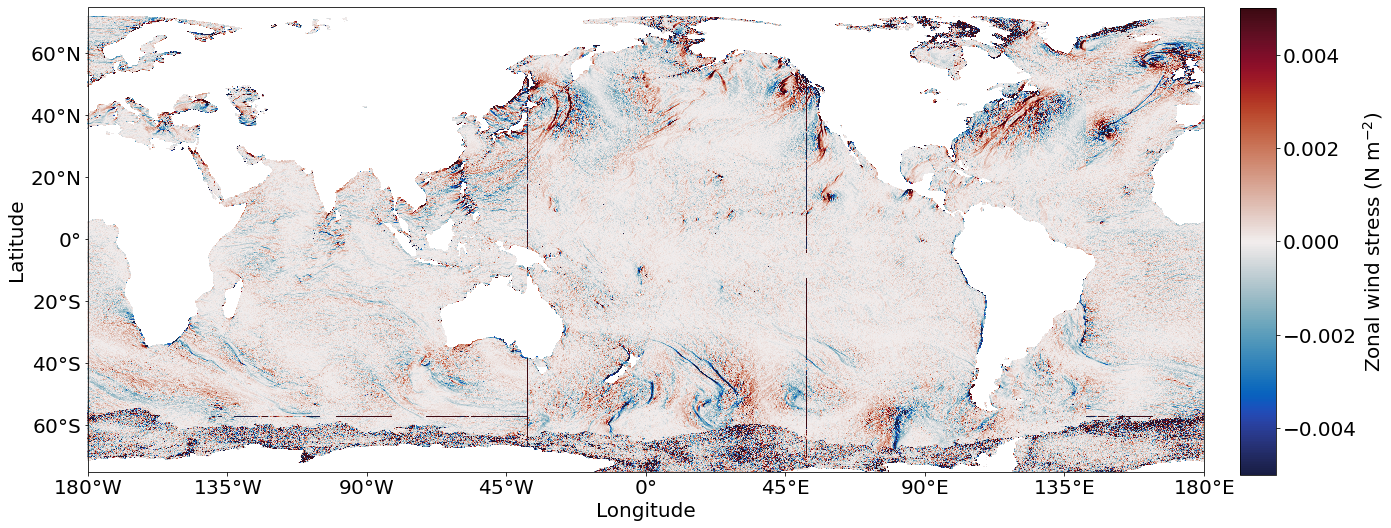

In [51]:
plot_pretty(ds_z.zeta.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)), label='Zonal wind stress (N m$^{-2}$)', vmin=-0.005, vmax=0.005, cmmap='balance', ignore_face=[6])

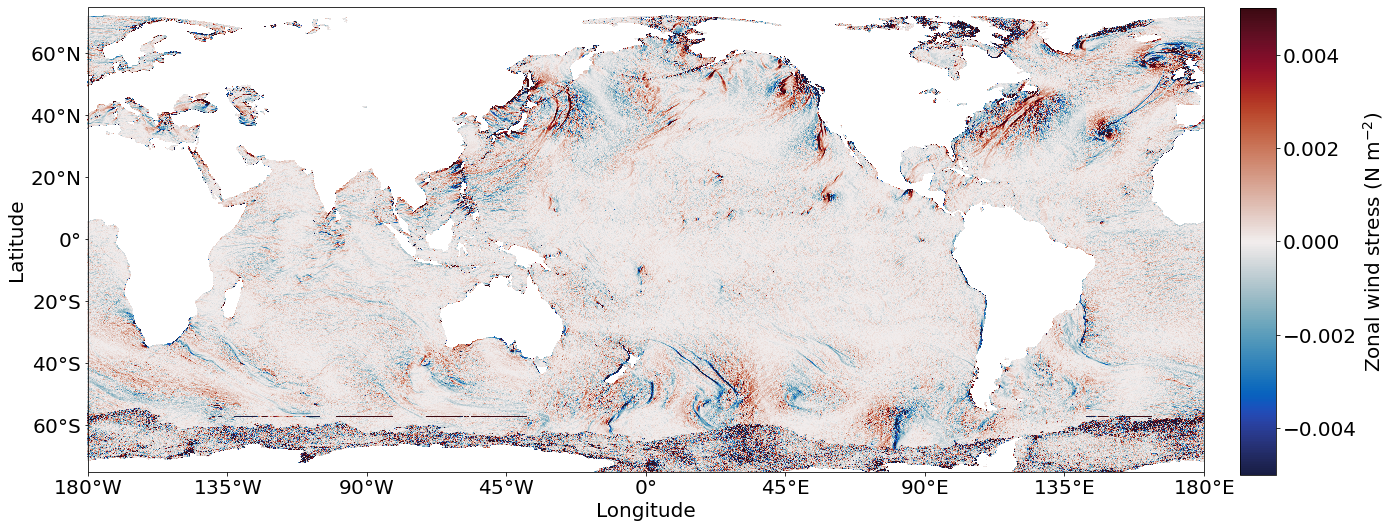

In [50]:
plot_pretty(ds_z.zeta, label='Zonal wind stress (N m$^{-2}$)', vmin=-0.005, vmax=0.005, cmmap='balance', ignore_face=[6])

In [12]:
cluster.close()